# Модель машиннго обучения - ElasticNet()!!!

In [1]:
# загружаем библиотеки
import pandas as pd # работа с данными / python data analysis library
import numpy as np # работа с числовыми данными / python numerical computing library
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library
%matplotlib inline

from sklearn.linear_model import ElasticNet # алгоритм линейной регрессии с регуляризацией L1, L2 / elasticnet regression regularization L1, L2

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка / mean absolute error
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка / mean squared error
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка / mean absolute percentage error

from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / 
from sklearn.feature_selection import SelectKBest, f_regression # алгоритм для выбора признаков с наивысшими оценками в модели машинного обучения на основе статистических тестов / f-regression одномерный тест линейной регрессии  
from sklearn.preprocessing import MinMaxScaler # алгоритм нормализация данных / min-max scaler

import optuna # библиотека для оптимизации параметров / python optimization library
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключаем вывод промежуточных итогов вычислений

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK # библиотека для оптимизации параметров / python optimization library

from joblib import dump, load # сохранение и загрузка модели / joblib library

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")

# фиксируем RANDOM_SEED, для воспроизводимости кода
RANDOM_SEED = 369

In [2]:
# %%time
# загружаем данные
data_en = pd.read_csv("data/data_final.csv", sep=",")

# создаем матрицу наблюдений и вектор правильных ответов
X = data_en.drop(columns="target", axis=1)
y = data_en["target"]

# производим разделение выборки на тренировочную, валидационную и тестовую
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=RANDOM_SEED)

# # производим отбор наиболее важных признаков
# selector = SelectKBest(score_func=f_regression, k=100)
# selector.fit(X_train, y_train)
# best_features = selector.get_feature_names_out()
# X_train = X_train[best_features]
# X_valid = X_valid[best_features]
# X_test = X_test[best_features]

# производим нормализацию данных с помощью MinMaxScaller
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

# строим и обучаем модель
model_en = ElasticNet()
model_en.fit(X_train, y_train)

# делаем предсказание
y_train_predict_en = model_en.predict(X_train)
y_valid_predict_en = model_en.predict(X_valid)
y_test_predict_en = model_en.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print('     RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_en))))
print('     MAE: {:.2f}'.format(mean_absolute_error(y_train, y_train_predict_en)))
print('     MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_train, y_train_predict_en)*100))
print("Валидационная выборка:")
print('     RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_en))))
print('     MAE: {:.2f}'.format(mean_absolute_error(y_valid, y_valid_predict_en)))
print('     MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_valid, y_valid_predict_en)*100))
print("Тестовая выборка:")
print('     RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_en))))
print('     MAE: {:.2f}'.format(mean_absolute_error(y_test, y_test_predict_en)))
print('     MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test, y_test_predict_en)*100))
# print(f"Коэффициент пересечения модели:, {model_en.intercept_}")
# print(f"Коэффициенты модели: {model_en.coef_}")


Тренировочная выборка:
     RMSE: 0.87
     MAE: 0.66
     MAPE: 5.23%
Валидационная выборка:
     RMSE: 0.87
     MAE: 0.66
     MAPE: 5.22%
Тестовая выборка:
     RMSE: 0.87
     MAE: 0.66
     MAPE: 5.22%


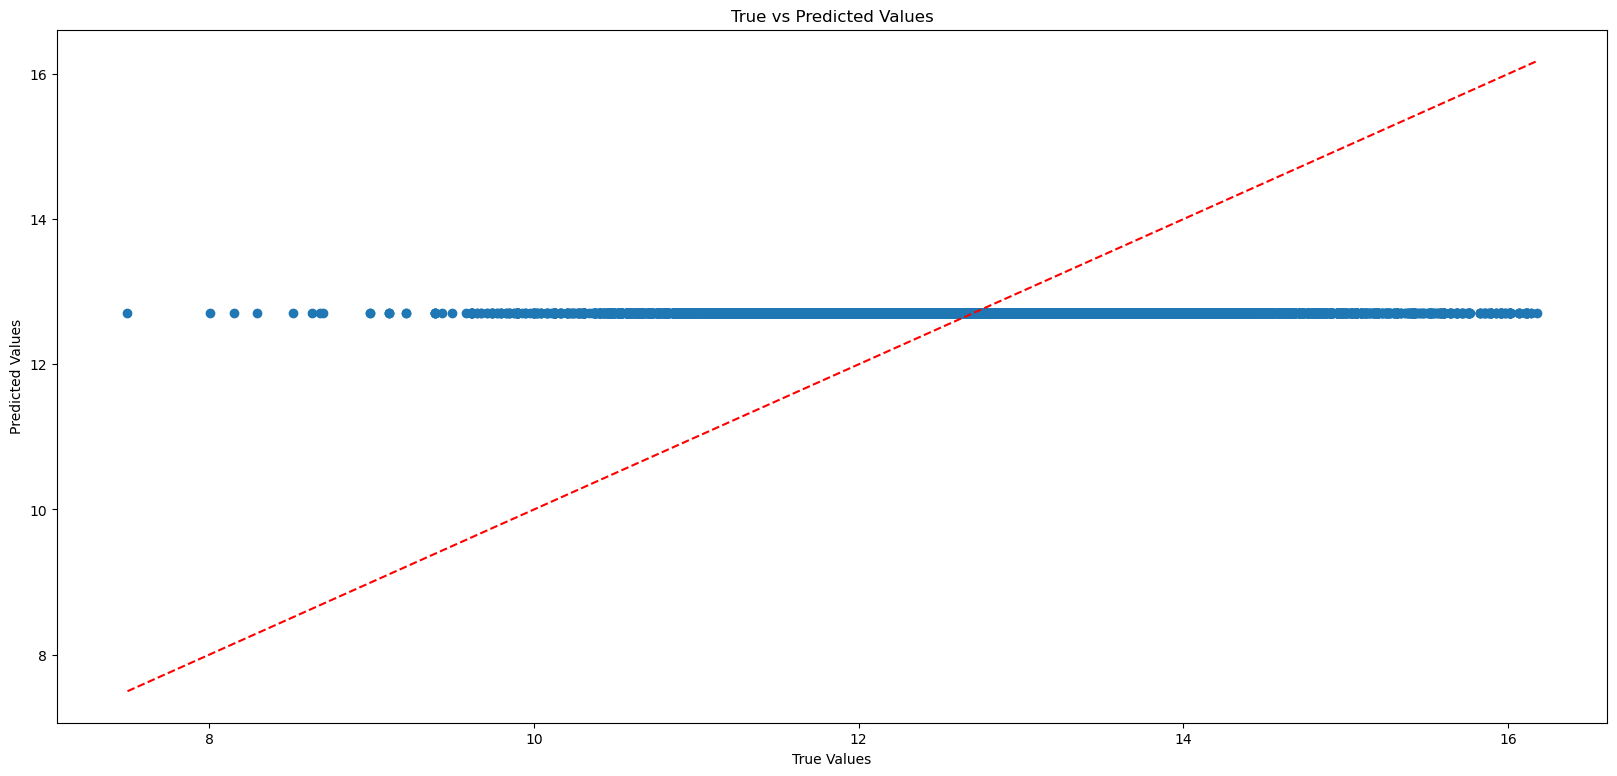

In [3]:
# график предсказанных значений против истинных значений на тестовой выборке
y_pred = y_test_predict_en
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

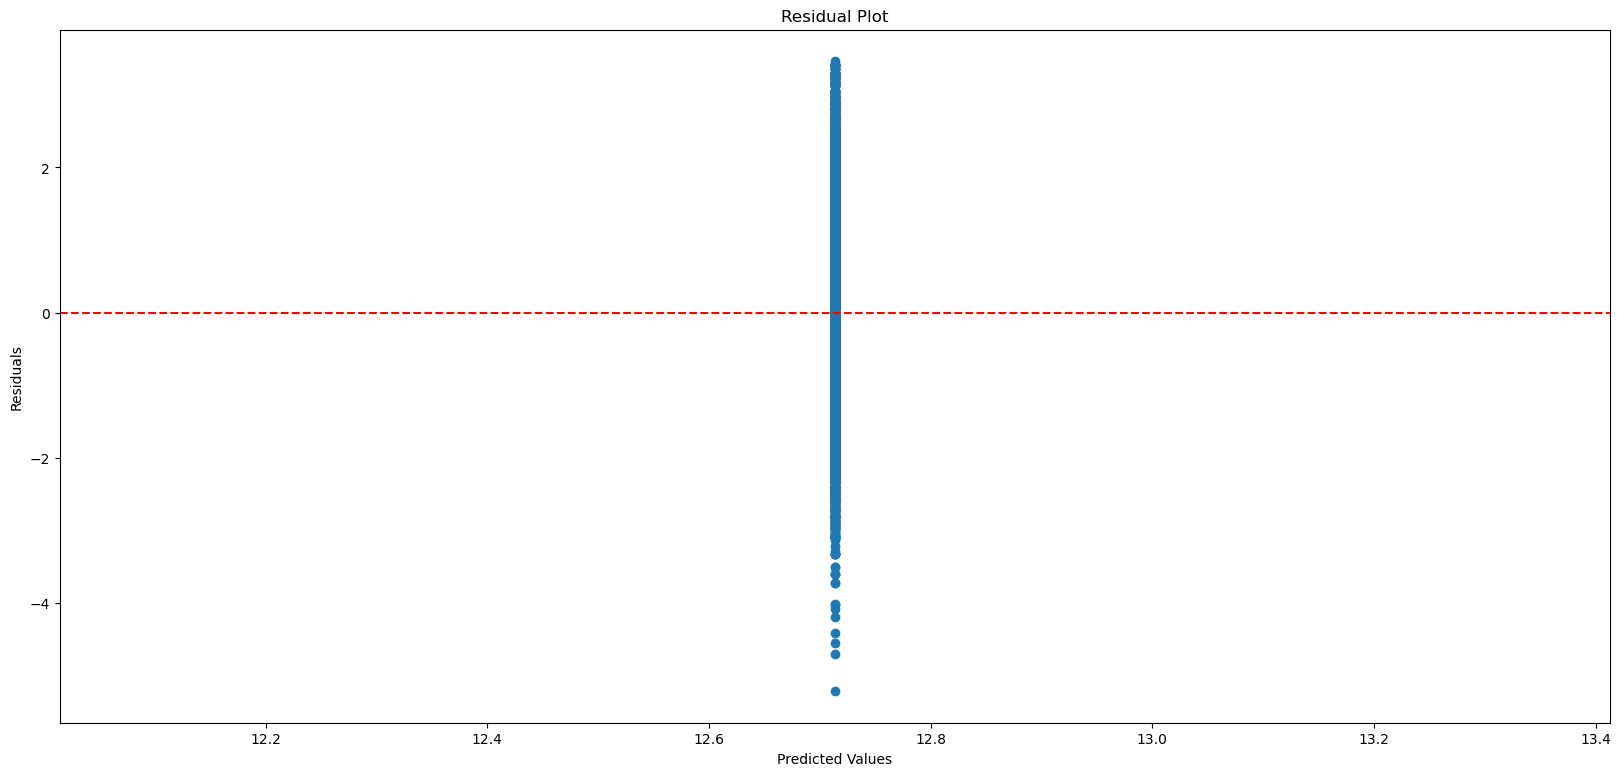

In [4]:
# график остатков на тестовой выборке
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [5]:
# cохраняем модель в файл
dump(model_en, "model/model_ElasticNet.joblib")

['model/model_ElasticNet.joblib']

#### Optimization model - **OPTUNA** - Подбор гиперпараметров

In [6]:
%%time
# описываем функцию подбора гиперпараметров
def optuna_function(trial):
    # определение пространства поиска гиперпараметров
    alpha = trial.suggest_float("alpha", 0.0, 10.0)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    # создание модели линейной регрессии с выбранным гиперпараметром
    optuna_en = ElasticNet(alpha=alpha,
                           l1_ratio=l1_ratio)
    # обучение модели и оценка качества
    optuna_en.fit(X_train, y_train)
    y_pred = optuna_en.predict(X_valid)

    mae = mean_absolute_error(y_valid, y_pred)

     # Сообщаем оптимизатору текущий результат
    trial.report(mae, step=0)

    # Проверяем, следует ли обрезать пробу
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return mae  # возвращаем значение среднеквадратичной ошибки для оптимизации

study = optuna.create_study(direction="minimize")
study.optimize(optuna_function, n_trials=500, show_progress_bar=True)

best_params = study.best_params

print(f"Лучшие параметры: {best_params}")

  0%|          | 0/500 [00:00<?, ?it/s]

Лучшие параметры: {'alpha': 0.00012534258441211567, 'l1_ratio': 0.4333327003266849}
CPU times: user 2h 53min 25s, sys: 9min 3s, total: 3h 2min 29s
Wall time: 15min 15s


In [7]:
# инициализируем и обучаем модель
model_en_optuna = ElasticNet(**best_params)
model_en_optuna.fit(X_train, y_train)
y_train_predict_en_optuna = model_en_optuna.predict(X_train)
y_valid_predict_en_optuna = model_en_optuna.predict(X_valid)
y_test_predict_en_optuna = model_en_optuna.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_en_optuna))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_en_optuna)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_en_optuna)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_en_optuna))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_en_optuna)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_en_optuna)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_en_optuna))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_en_optuna)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_en_optuna)*100))


Тренировочная выборка:
     RMSE: 0.54
     MAE: 0.40
     MAPE: 3.16%
Валидационная выборка:
     RMSE: 0.54
     MAE: 0.40
     MAPE: 3.17%
Тестовая выборка:
     RMSE: 0.55
     MAE: 0.40
     MAPE: 3.19%


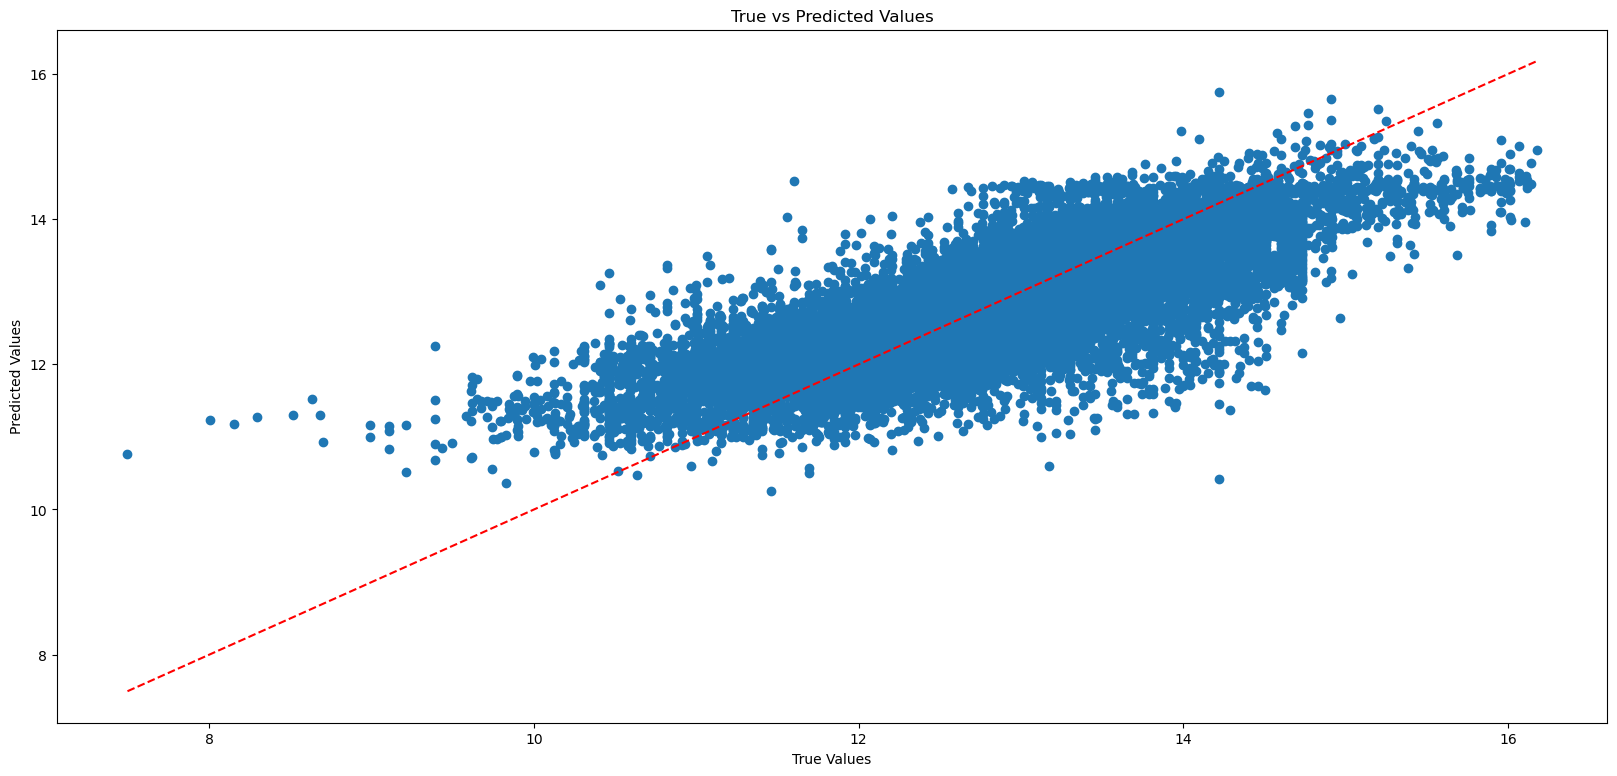

In [8]:
# график предсказанных значений против истинных значений на тестовой выборке
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_en_optuna)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

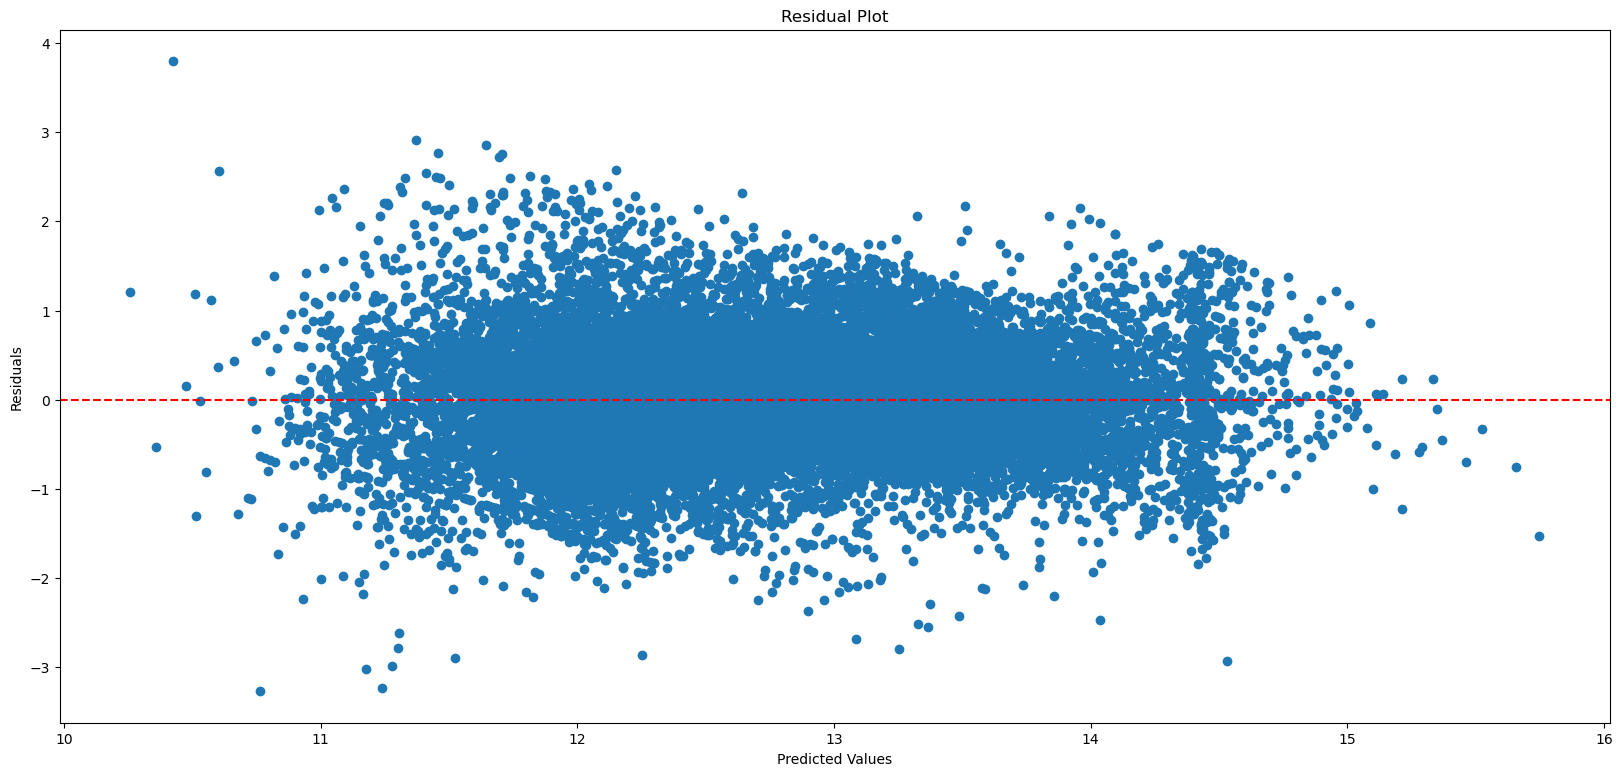

In [9]:
# график остатков на тестовой выборке
residuals = y_test - y_test_predict_en_optuna
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_en_optuna, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [10]:
# формируем и выводим график истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name="mae")

In [11]:
# формируем и выводим график важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="mae")

In [12]:
# формируем и выводим график связи комбинаций гиперпараметров и целевой метрики
optuna.visualization.plot_contour(study, params=["alpha", "l1_ratio"],
                                  target_name="mae")

In [13]:
# визуализация среза
optuna.visualization.plot_slice(study, target_name="mae")

In [14]:
# визуализация промежуточных значений (полезна, если вы используете промежуточные значения во время оптимизации)
optuna.visualization.plot_intermediate_values(study)

In [15]:
# визуализация прогресса оптимизации для параллельной координатной плоскости
optuna.visualization.plot_parallel_coordinate(study, target_name="mae")

In [16]:
# визуализация соотношения гиперпараметров к целевой метрике
optuna.visualization.plot_edf(study, target_name="mae")

In [17]:
# cохраняем модель в файл
dump(model_en_optuna, "model/model_ElasticNetOptuna.joblib")

['model/model_ElasticNetOptuna.joblib']

#### Optimization model - **Hyperopt** - Подбор гиперпараметров

In [18]:
# описываем функцию подбора гиперпараметров
def hyperopt_function(params):
    # создание модели с текущими гиперпараметрами
    en = ElasticNet(alpha=params["alpha"], l1_ratio=params["l1_ratio"])
    # обучение модели и оценка качества
    en.fit(X_train, y_train)
    y_pred = en.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return {"loss": mae, "status": STATUS_OK}

# определение пространства поиска гиперпараметров
space = {
    "alpha": hp.uniform("alpha", 0.0, 10.0),
    "l1_ratio": hp.uniform("l1_ratio", 0.0, 1.0)
}

# запускаем оптимизацию
trials = Trials()
best = fmin(
    fn=hyperopt_function,
    space=space,
    algo=tpe.suggest,
    max_evals=300,
    trials=trials
)

print(f"Лучшие параметры: {best}")

100%|██████████| 300/300 [04:22<00:00,  1.14trial/s, best loss: 0.4051557116148243] 
Лучшие параметры: {'alpha': 0.001008762890253396, 'l1_ratio': 0.056137761134908024}


In [19]:
# продолжим подбор параметров, увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) и используем старый trials
best=fmin(hyperopt_function, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=500, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RANDOM_SEED) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 500/500 [05:01<00:00,  1.51s/trial, best loss: 0.40159239115977735]
Наилучшие значения гиперпараметров {'alpha': 0.0003280015490680695, 'l1_ratio': 0.16478572454881218}


In [20]:
# инициализируем и обучаем модель
model_en_hyperopt = ElasticNet(**best)
model_en_hyperopt.fit(X_train, y_train)
y_train_predict_en_hyperopt = model_en_hyperopt.predict(X_train)
y_valid_predict_en_hyperopt = model_en_hyperopt.predict(X_valid)
y_test_predict_en_hyperopt = model_en_hyperopt.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_en_hyperopt))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_en_hyperopt)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_en_hyperopt)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_en_hyperopt))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_en_hyperopt)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_en_hyperopt)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_en_hyperopt))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_en_hyperopt)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_en_hyperopt)*100))


Тренировочная выборка:
     RMSE: 0.54
     MAE: 0.40
     MAPE: 3.17%
Валидационная выборка:
     RMSE: 0.54
     MAE: 0.40
     MAPE: 3.18%
Тестовая выборка:
     RMSE: 0.55
     MAE: 0.40
     MAPE: 3.20%


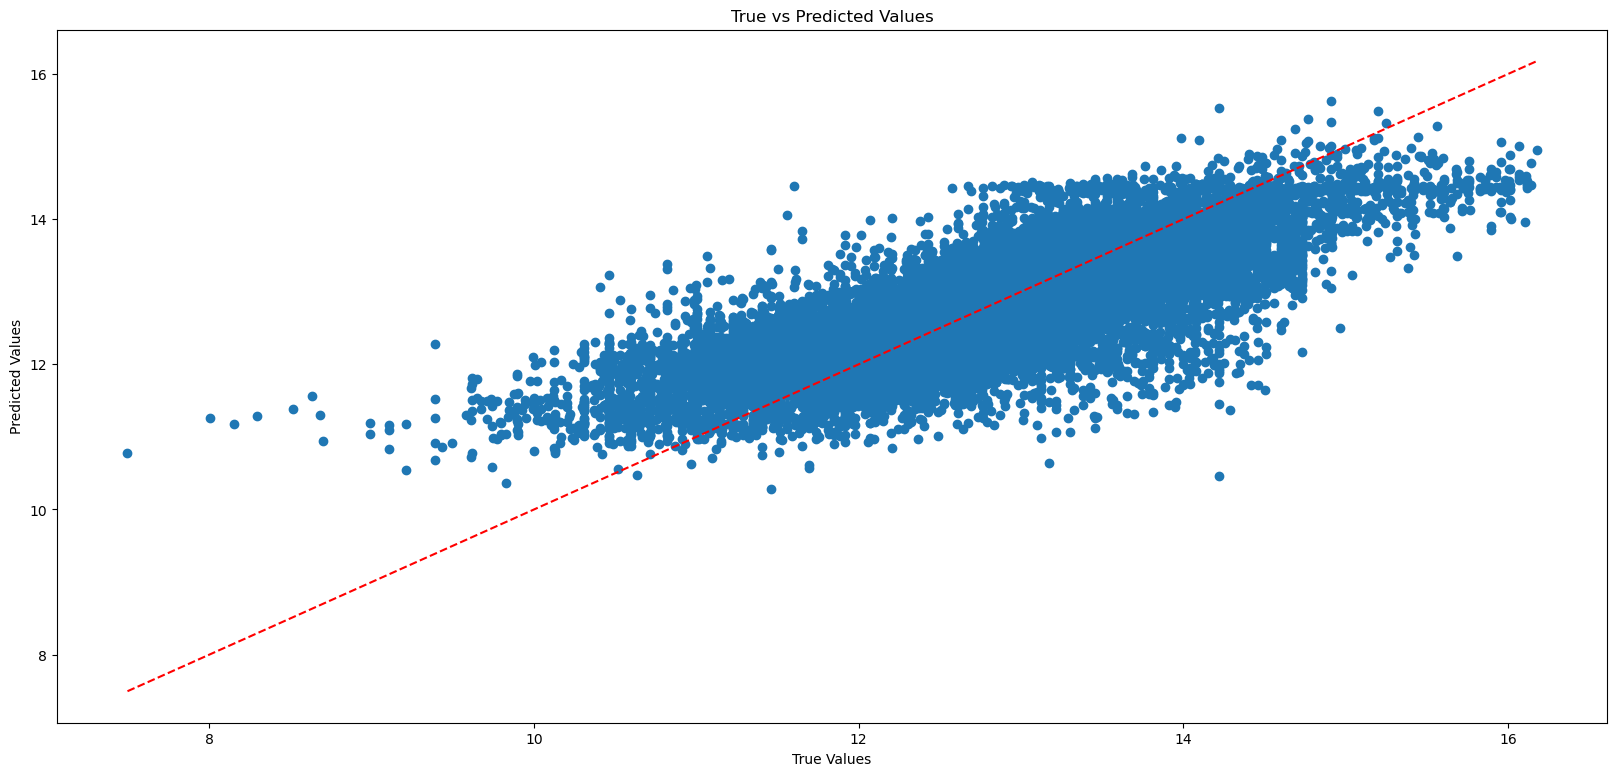

In [21]:
# график предсказанных значений против истинных значений
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_en_hyperopt)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

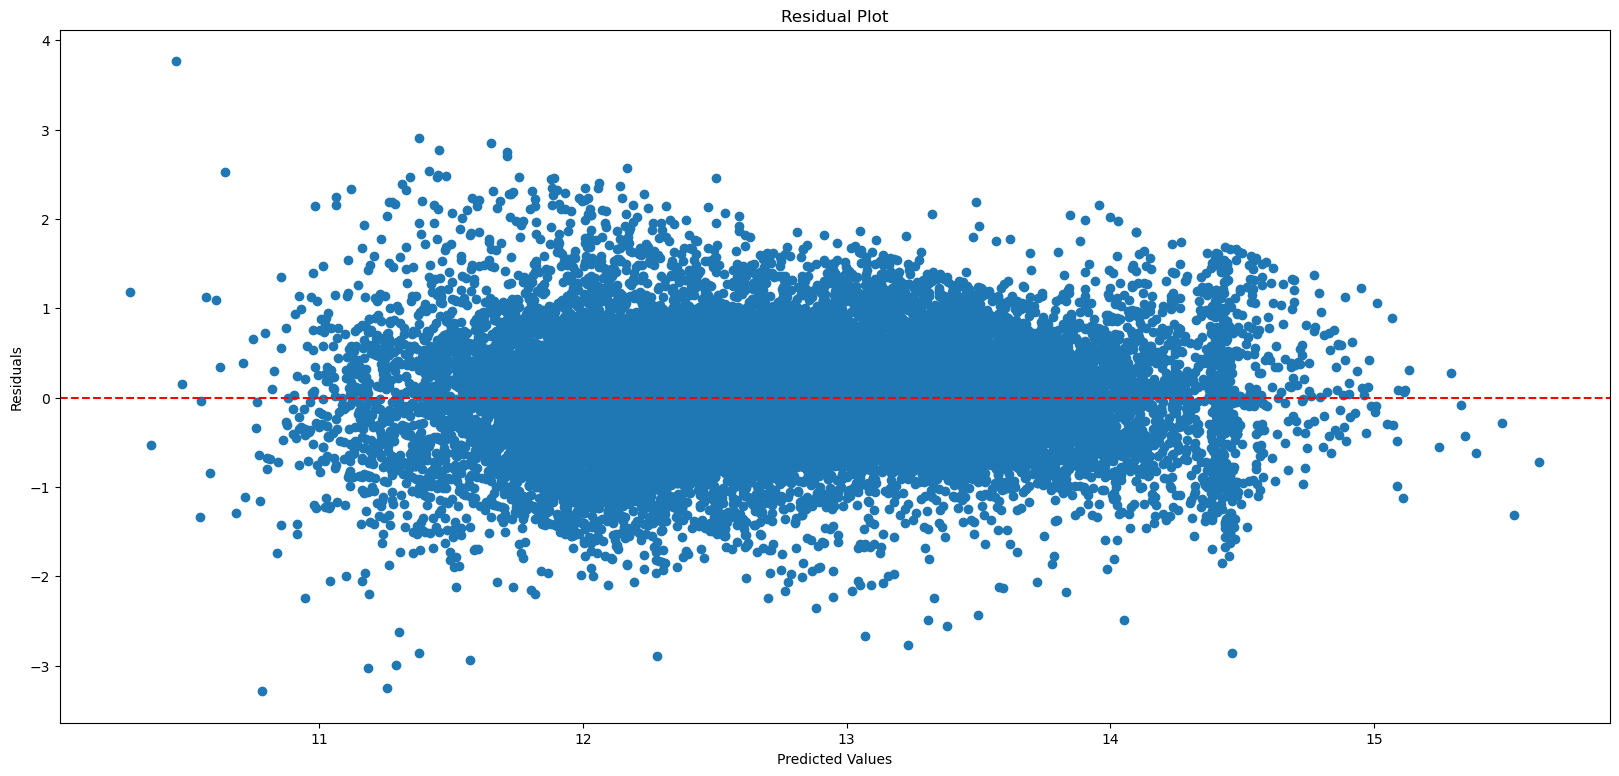

In [22]:
# график остатков
residuals = y_test - y_test_predict_en_hyperopt
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_en_hyperopt, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

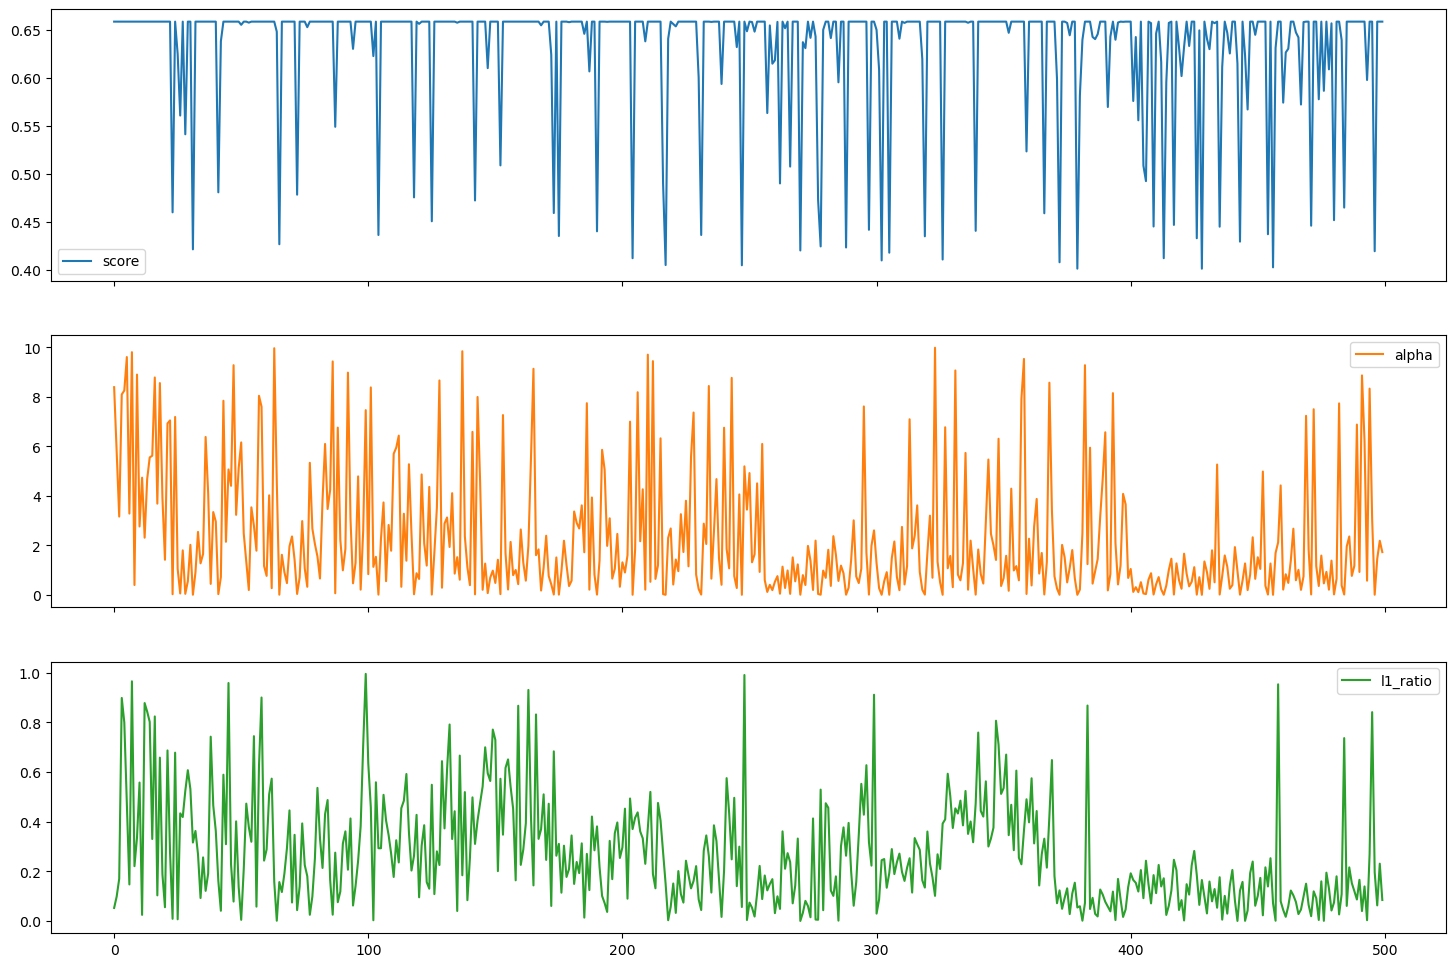

In [23]:
# формируем и выводим график, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x["result"]["loss"],
                      x["misc"]["vals"]["alpha"][0],
                      x["misc"]["vals"]["l1_ratio"][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=["score", "alpha", "l1_ratio"])
# тепловая карта в данном случае не наглядна, применяем линейный график
tpe_results_df.plot(subplots=True,figsize=(18, 12))

In [24]:
# cохраняем модель в файл c подобранными гиперпараметрами
dump(model_en_hyperopt, "model/model_ElasticNetHyperopt.joblib")

['model/model_ElasticNetHyperopt.joblib']

In [25]:
# в данную переменную буду сохранять результаты моделей [RSME, MAE, MAPE и название алгоритма]
results = []

# описываем функцию для оценки модели, а также для сохранения значений метрик и последующего использования
def results_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, results):
  """Функция для вывода результатов score для train, valid и test, а также для сохранения этих значений для последующего использования.
    
  Аргументы:
    model (model): обученная модель, которую необходимо оценить;
    model_name (string): название используемой модели.
  """
  model_result = []
  # предсказания и оценка для тренировочных данных
  y_train = np.expm1(y_train)
  y_train_pred = np.expm1(model.predict(X_train))
  RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
  MAE_train = mean_absolute_error(y_train, y_train_pred).round(3)
  MAPE_train = (mean_absolute_percentage_error(y_train, y_train_pred) * 100).round(3)
  # вывод результатов для тренировочных данных
  # print(f"Тренировочная выборка:")
  # print(f"    RMSE: {RMSE_train:.3f}")
  # print(f"    MAE: {MAE_train:.3f}")
  # print(f"    MAPE: {MAPE_train:.2f}%")
  
  # предсказания и оценка для валидационных данных
  y_valid = np.expm1(y_valid)
  y_valid_pred = np.expm1(model.predict(X_valid))
  RMSE_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred)).round(3)
  MAE_valid = mean_absolute_error(y_valid, y_valid_pred).round(3)
  MAPE_valid = (mean_absolute_percentage_error(y_valid, y_valid_pred) * 100).round(3)
  # вывод результатов для валидационных данных
  # print(f"Валидная выборка:")
  # print(f"    RMSE: {RMSE_valid:.3f}")
  # print(f"    MAE: {MAE_valid:.3f}")
  # print(f"    MAPE: {MAPE_valid:.2f}%")
  
  # предсказания и оценка для тестовых данных
  y_test = np.expm1(y_test)
  y_test_pred = np.expm1(model.predict(X_test))
  RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)
  MAE_test = mean_absolute_error(y_test, y_test_pred).round(3)
  MAPE_test = (mean_absolute_percentage_error(y_test, y_test_pred) * 100).round(3)
  # вывод результатов для тестовых данных
  # print(f"Тестовая выборка:")
  # print(f"    RMSE: {RMSE_test:.3f}")
  # print(f"    MAE: {MAE_test:.3f}")
  # print(f"    MAPE: {MAPE_test:.2f}%") 
  
  # сохранение результатов в список model_results
  results.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # сохранение результатов в список model_results
  model_result.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # создаем dataframe с результатами
  resultmodelScoreData = pd.DataFrame(model_result).set_index('ML_model').sort_values(by='MAPE_test', ascending=True)
  # выводим сводную информацию 
  display(resultmodelScoreData.sort_values(by="MAE_test", ascending=True).round(2))

In [26]:
# делаем предсказания на тренировочной, валидной и тестовой выборках и выводим результат
print("Модель ElasticNet:")
results_model(model_en, X_train, y_train, X_valid, y_valid, X_test, y_test, "ElasticNet", results)
print()
print("Модель ElasticNetOptuna - с подбором гиперпараметров (библиотека Optuna):")
results_model(model_en_optuna, X_train, y_train, X_valid, y_valid, X_test, y_test, "ElasticNetOptuna", results)
print()
print("Модель ElasticNetHyperopt - с подбором гиперпараметров (библиотека Hyperopt):")
results_model(model_en_hyperopt, X_train, y_train, X_valid, y_valid, X_test, y_test, "ElasticNetHyperopt", results)

Модель ElasticNet:


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
ElasticNet,666459.73,303319.18,90.56,687038.53,310344.25,87.86,692925.79,307156.49,89.59



Модель ElasticNetOptuna - с подбором гиперпараметров (библиотека Optuna):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
ElasticNetOptuna,478334.12,201317.52,45.17,492037.65,206860.58,44.95,503265.98,206216.58,45.23



Модель ElasticNetHyperopt - с подбором гиперпараметров (библиотека Hyperopt):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
ElasticNetHyperopt,478675.04,201480.64,45.35,493041.89,207089.81,45.09,503868.7,206423.31,45.38
